## Benchmark Goal

In [1]:
# GOAL: check if the elbow method applied on the statistic of the KS Test 
# could give as good results as the energy test. 
# INTUITION: maybe the threshold of 0.05 p-value is not adapt for this problem

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
import os

In [2]:
config_train = load_config_and_check("../config/experiment_v09.yaml")
config_test = load_config_and_check("../config/experiment_v10.yaml")

In [213]:
OUT_IMAGE_PATH = "../data/paper_images"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from analyser import Explorer

## Training: identify the thresholds (median/50%)

In [186]:
exp_train = Explorer(config_train)

--- PROGRAM INFO ---
- BENCHMARK: qasm_bench_mid ...  
- BENCHMARK: tket_bench_1 ...  
- BENCHMARK: across_runs_qiskit ...  
- BENCHMARK: across_runs_cirq ...  
- BENCHMARK: program_vs_random ...  
- BENCHMARK: negation ...  
- BENCHMARK: program_x_vs_program_y ...  
--- EXECUTION INFO ---
- BENCHMARK: qasm_bench_mid ...  
- BENCHMARK: tket_bench_1 ...  
- BENCHMARK: across_runs_qiskit ...  
- BENCHMARK: across_runs_cirq ...  
- BENCHMARK: program_vs_random ...  
- BENCHMARK: negation ...  
- BENCHMARK: program_x_vs_program_y ...  
--- GROUND TRUTH ---
- BENCHMARK: qasm_bench_mid) ...  
- BENCHMARK: tket_bench_1) ...  
- BENCHMARK: across_runs_qiskit) ...  
- BENCHMARK: across_runs_cirq) ...  
- BENCHMARK: program_vs_random) ...  
- BENCHMARK: negation) ...  
- BENCHMARK: program_x_vs_program_y) ...  
--- DETECTOR DATA ---
 - BENCHMARK: qasm_bench_mid - DETECTOR: ../data/experiment_v09/qasm_bench_mid/predictions/energy.  
 - BENCHMARK: qasm_bench_mid - DETECTOR: ../data/experiment_v09/

In [187]:
len(exp_train.df_all)

1833

In [188]:
df = exp_train.df_all
series = df["test"]
print(series)

0      energy
1          ks
2      energy
3          ks
4      energy
        ...  
606    random
607    random
608    random
609    random
610    random
Name: test, Length: 1833, dtype: object


We have displayed 611/611 datapoints.
[benchmark restriction: None]
We have displayed 611/611 datapoints.
[benchmark restriction: None]


<AxesSubplot:title={'center':'Distribution of Energy statistic (TRAINING)'}, xlabel='statistic', ylabel='Count'>

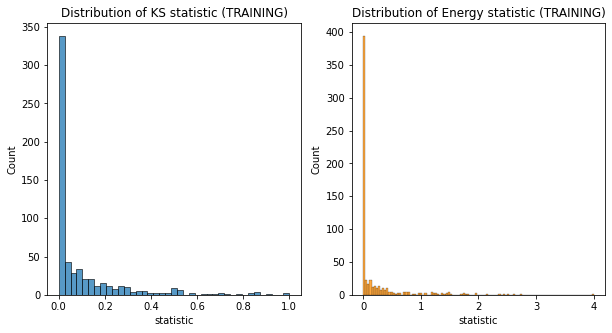

In [190]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax_ks = axes[0]
ax_energy = axes[1]

exp_train.focus_on_detector(detector_name='ks')
exp_train.inspect(
    variable_to_inspect='statistic', 
    title="Distribution of KS statistic (TRAINING)",
    ax=ax_ks
)

exp_train.focus_on_detector(detector_name='energy')
exp_train.inspect(
    variable_to_inspect='statistic', 
    title="Distribution of Energy statistic (TRAINING)",
    ax=ax_energy,
    color='darkorange'
)

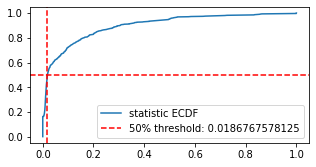

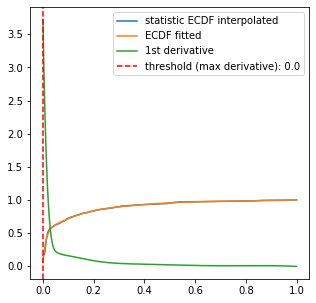

In [221]:
fig_ecdf, ax_ecdf = plt.subplots(figsize=(5, 2.5))

fig_derviv, ax_deriv = plt.subplots(figsize=(5, 5))
threshold_ks = exp_train.plot_ECDF(test_name="ks", variable="statistic", 
                                   ax_ecdf=ax_ecdf, ax_deriv=ax_deriv)
fig_ecdf.savefig(os.path.join(OUT_IMAGE_PATH, "threshold_method.pdf"), format="pdf")

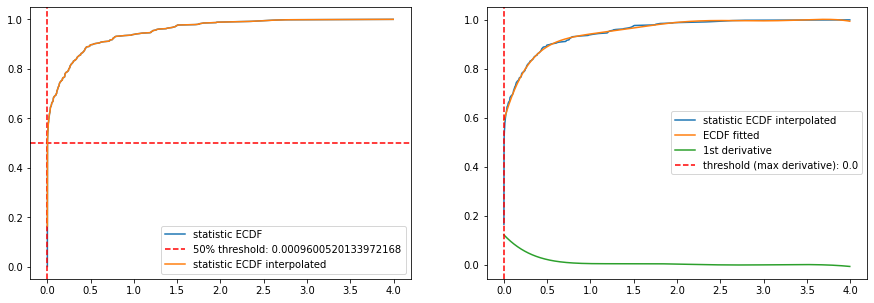

In [192]:
threshold_energy = exp_train.plot_ECDF(test_name="energy", variable="statistic")

## Testing: Benchmark Categories

In [206]:
exp_test = Explorer(config_test)

--- PROGRAM INFO ---
- BENCHMARK: qasm_bench_mid ...  
- BENCHMARK: tket_bench_1 ...  
- BENCHMARK: across_runs_qiskit ...  
- BENCHMARK: across_runs_cirq ...  
- BENCHMARK: program_vs_random ...  
- BENCHMARK: negation ...  
- BENCHMARK: program_x_vs_program_y ...  
--- EXECUTION INFO ---
- BENCHMARK: qasm_bench_mid ...  
- BENCHMARK: tket_bench_1 ...  
- BENCHMARK: across_runs_qiskit ...  
- BENCHMARK: across_runs_cirq ...  
- BENCHMARK: program_vs_random ...  
- BENCHMARK: negation ...  
- BENCHMARK: program_x_vs_program_y ...  
--- GROUND TRUTH ---
- BENCHMARK: qasm_bench_mid) ...  
- BENCHMARK: tket_bench_1) ...  
- BENCHMARK: across_runs_qiskit) ...  
- BENCHMARK: across_runs_cirq) ...  
- BENCHMARK: program_vs_random) ...  
- BENCHMARK: negation) ...  
- BENCHMARK: program_x_vs_program_y) ...  
--- DETECTOR DATA ---
 - BENCHMARK: qasm_bench_mid - DETECTOR: ../data/experiment_v10/qasm_bench_mid/predictions/energy.  
 - BENCHMARK: qasm_bench_mid - DETECTOR: ../data/experiment_v10/

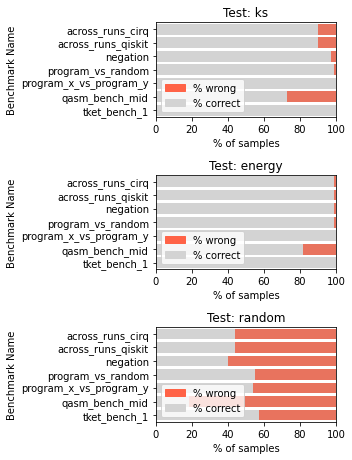

In [226]:
fig, axes = plt.subplots(3, 1, figsize=(5, 6.5))
ax_ks = axes[0]
ax_energy = axes[1]
ax_random = axes[2]

exp_test.reset_test_level(detector_name='random')
exp_test.classify_based_on(col_name="p_value", threshold=0.5, reject_if_low=True)
exp_test.plot_benchmark_categories(ax=ax_random)

exp_test.reset_test_level(detector_name='ks')
exp_test.classify_based_on(col_name="statistic", threshold=threshold_ks, reject_if_low=False)
exp_test.plot_benchmark_categories(ax=ax_ks)

exp_test.reset_test_level(detector_name='energy')
exp_test.classify_based_on(col_name="statistic", threshold=threshold_energy, reject_if_low=False)
exp_test.plot_benchmark_categories(ax=ax_energy)

plt.tight_layout()
fig.savefig(os.path.join(OUT_IMAGE_PATH, "perf_benchmark_categories.pdf"), format="pdf")


## Testing: ROC-AUC

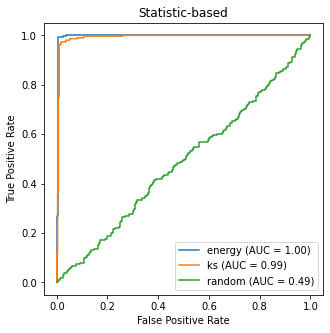

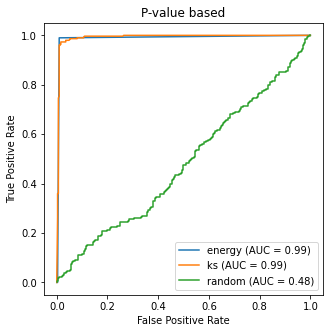

In [223]:
fig, ax = plt.subplots(figsize=(5, 5))
exp_test.plot_ROC(prediction_column="p_value", low_reject=True, title="P-value based")
exp_test.plot_ROC(prediction_column="statistic", low_reject=False, title="Statistic-based", ax=ax)
fig.savefig(os.path.join(OUT_IMAGE_PATH, "perf_benchmark_ROC_AUC.pdf"), format="pdf")

## Dataset Distribution 

In [242]:
from collections import Counter

exp_test.reset()
df_all = exp_test.df_all
# get results for only one test
df_all = df_all[df_all["test"] == "ks"]
n_records = len(df_all)

cnt = Counter(df_all["expected_divergence"])

n_true_divergence_benchmark = cnt[True]
perc_true_divergence_benchmark = (n_true_divergence_benchmark / n_records) * 100
n_false_divergence_benchmark = cnt[False]
perc_false_divergence_benchmark = (n_false_divergence_benchmark / n_records) * 100

print("\\newcommand{\\nTrueDivergenceBenchmark}{" + f"{n_true_divergence_benchmark:.0f}" + "}")
print("\\newcommand{\\percTrueDivergenceBenchmark}{" + f"{perc_true_divergence_benchmark:.1f}\\%" + "}")
print("\\newcommand{\\nFalseDivergenceBenchmark}{" + f"{n_false_divergence_benchmark:.0f}" + "}")
print("\\newcommand{\\percFalseDivergenceBenchmark}{" + f"{perc_false_divergence_benchmark:.1f}\\%" + "}")

\newcommand{\nTrueDivergenceBenchmark}{300}
\newcommand{\percTrueDivergenceBenchmark}{49.1\%}
\newcommand{\nFalseDivergenceBenchmark}{311}
\newcommand{\percFalseDivergenceBenchmark}{50.9\%}


## Old elbow zoom

In [8]:
def plot_elbow_with_threshold(df, threshold=0.5):
    """Visualize the elbow diagram with a potential threshold."""
    fig, axes = plt.subplots(1, 3, figsize=(15,3))
    ax_super_zoom = axes[2]
    ax_zoom = axes[1]
    ax_normal = axes[0]

    sns.ecdfplot(
        data=df,
        x="statistic",
        ax=ax_normal
    )
    ax_normal.set_title("Full Scale")

    sns.ecdfplot(
        data=df,
        x="statistic",
        ax=ax_zoom
    )
    ax_zoom.set_xlim(0,0.05)
    ax_zoom.set_title("Zoom")

    sns.ecdfplot(
        data=df,
        x="statistic",
        ax=ax_super_zoom
    )
    ax_super_zoom.set_xlim(0,0.007)
    ax_super_zoom.set_title("Super Zoom")

    THRESHOLD_ON_STATISTIC = .001
    ax_normal.axvline(x=threshold, color='r')
    ax_zoom.axvline(x=threshold, color='r')
    ax_super_zoom.axvline(x=threshold, color='r')
    print(f"We raise an alert for all the data with a statistic higher than: {threshold}")

We raise an alert for all the data with a statistic higher than: 0.02


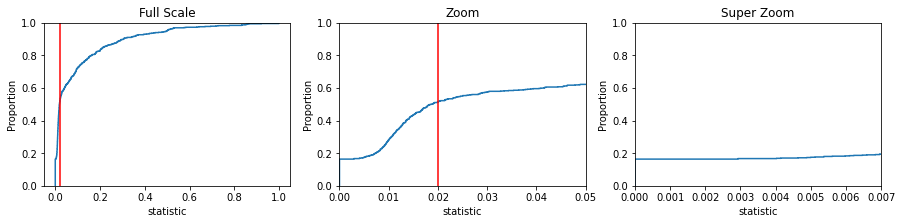

In [9]:
plot_elbow_with_threshold(df=df_ks, threshold=0.02)